# Acoustic FWI parametrized in velocity using only refractions

## Author: M. Ravasi

This notebook performs acoustic FWI parametrized in velocity using only refracted arrivals. It is mostly aimed at showcasing the ``devitofwi.preproc.masking.TimeSpaceMasking`` method to mask both the observed and modelled data (the latter as part of the objective function computation).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from devito import configuration
from pylops.basicoperators import Diagonal, Identity

from tqdm.notebook import tqdm
from examples.seismic import AcquisitionGeometry, Model, Receiver
from examples.seismic import plot_velocity, plot_perturbation
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_shotrecord

from devitofwi.devito.utils import clear_devito_cache
from devitofwi.waveengine.acoustic import AcousticWave2D
from devitofwi.preproc.masking import TimeSpaceMasking
from devitofwi.loss.l2 import L2
from devitofwi.postproc.acoustic import create_mask_value, PostProcessVP

configuration['log-level'] = 'ERROR'

/home/ravasim/Documents/2024/Projects/Devito-fwi/devitofwi/waveengine/acoustic.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# clear_devito_cache()

In [3]:
# Callback to track model error
def fwi_callback(xk, vp, vp_error):
    vp_error.append(np.linalg.norm((xk - vp.reshape(-1))/vp.reshape(-1)))

## Parameters 

In [4]:
# Model and aquisition parameters (in km, s, and Hz units)
par = {'nx':601,   'dx':0.015,    'ox':0,
       'nz':221,   'dz':0.015,    'oz':0,
       'ns':20,    'ds':0.300,    'os':1.,  'sz':0,
       'nr':300,   'dr':0.030,    'or':0,   'rz':0,
       'nt':3000,  'dt':0.002, 'ot':0,
       'freq':7,
      }

# Modelling parameters
shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
space_order = 4
nbl = 20

# Velocity model
path = '../../data/'
velocity_file = path + 'Marm.bin'

# Time-space mask parameters
vwater = 1.5
toff = 0.35

## Acquisition set-up

In [5]:
# Sampling frequency
fs = 1 / par['dt'] 

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1]

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz']

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz']

## Velocity model

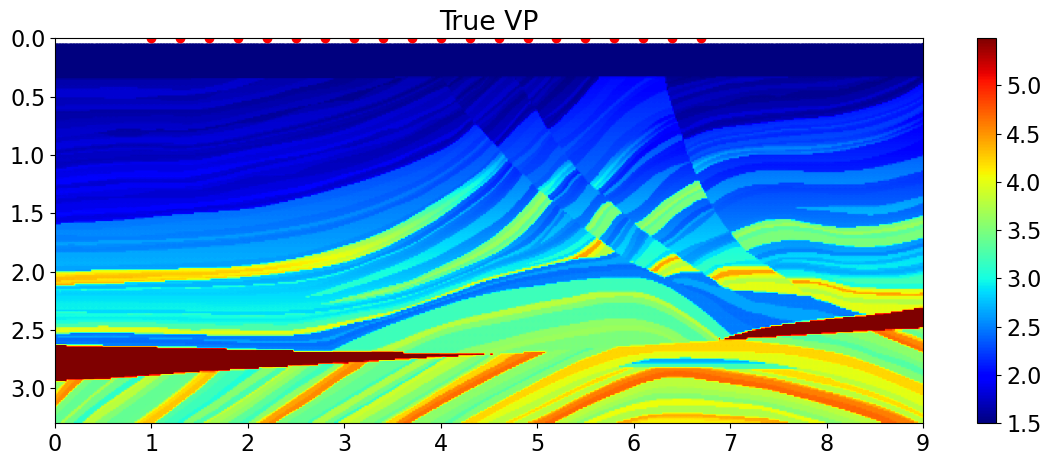

In [6]:
# Load the true model
vp_true = np.fromfile(velocity_file, np.float32).reshape(par['nz'], par['nx']).T
msk = create_mask_value(vp_true, 1.52) # get the mask for the water layer 

m_vmin, m_vmax = np.percentile(vp_true, [2,98]) 

plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('True VP')
plt.axis('tight');

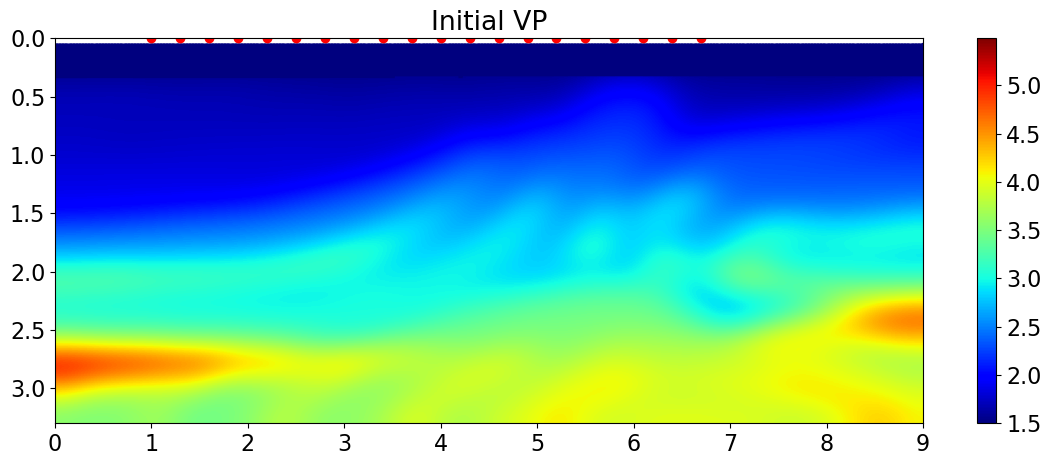

In [7]:
# Initial model for FWI by smoothing the true model
vp_init = gaussian_filter(vp_true, sigma=[15,10])
vp_init = vp_init * msk  # to preserve the water layer  
vp_init[vp_init == 0] = 1.5

plt.figure(figsize=(14, 5))
plt.imshow(vp_init.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Initial VP')
plt.axis('tight');

## Data modelling

In [8]:
# Define modelling engine
amod = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,  
                      vp=vp_true, 
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl,
                      clearcache=False)

# Create model and geometry to extract useful information to define the filtering object
model, geometry = amod.model_and_geometry()

In [9]:
# Model data
dobs, dtobs = amod.mod_allshots()

  0%|          | 0/20 [00:00<?, ?it/s]

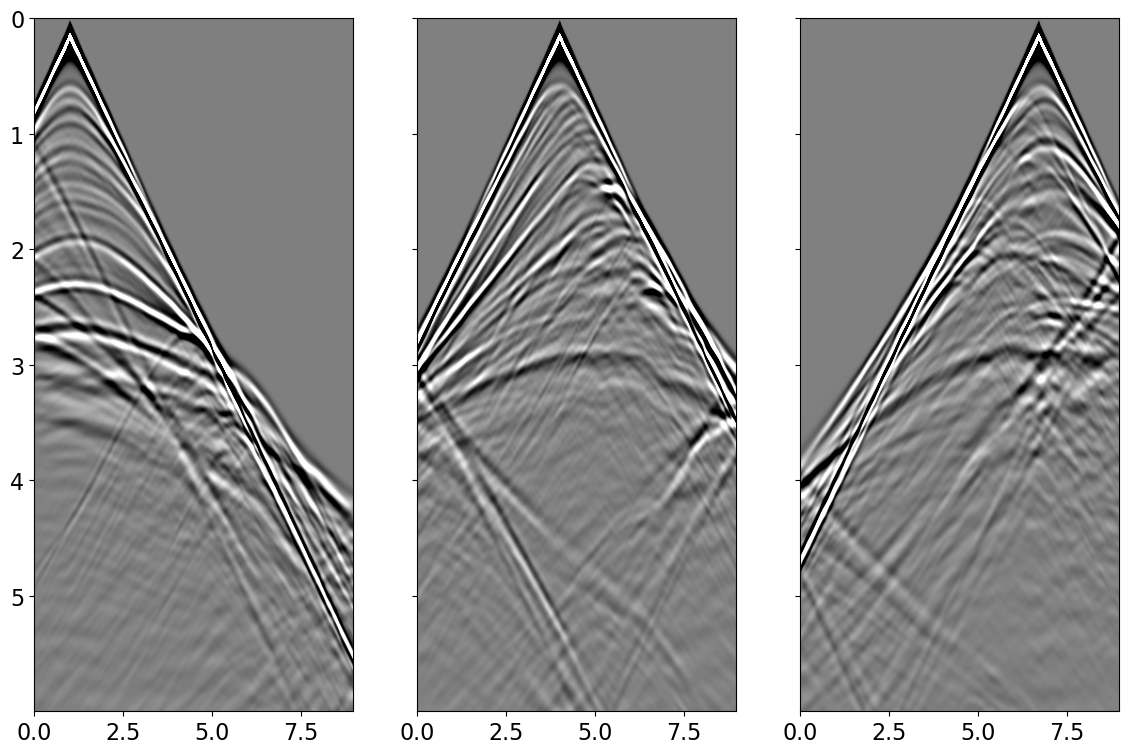

In [10]:
# Plot shot gathers
d_vmin, d_vmax = np.percentile(np.hstack(dobs).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)

## Mask creation

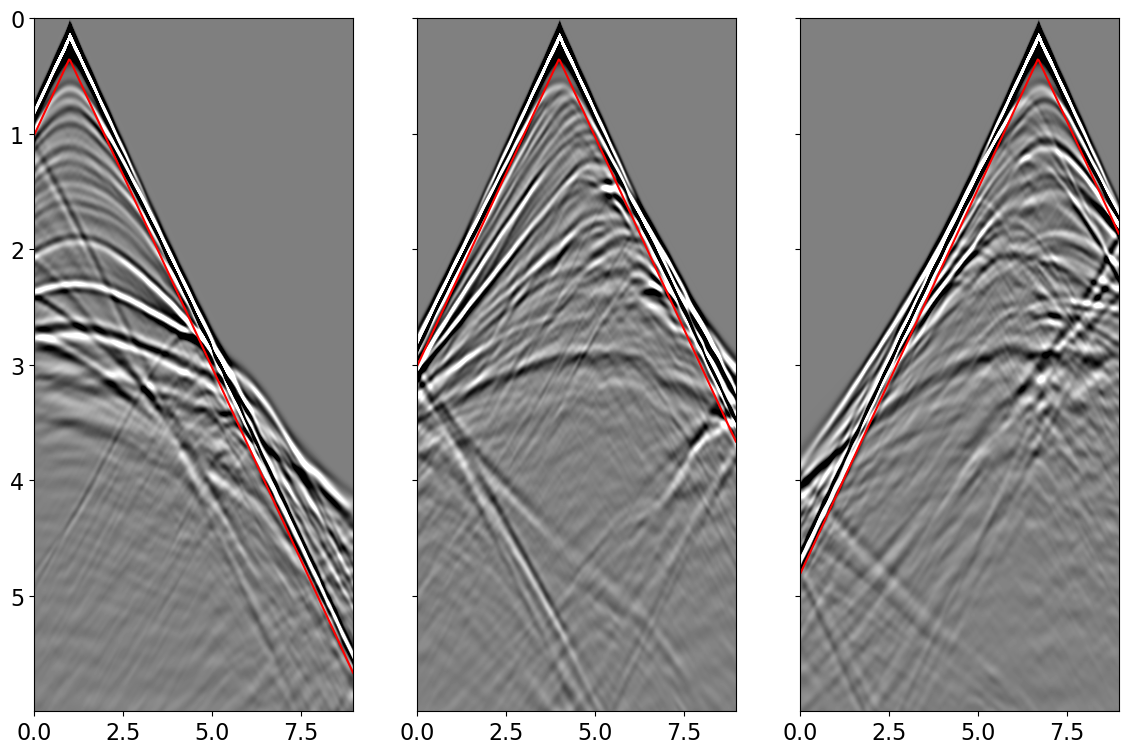

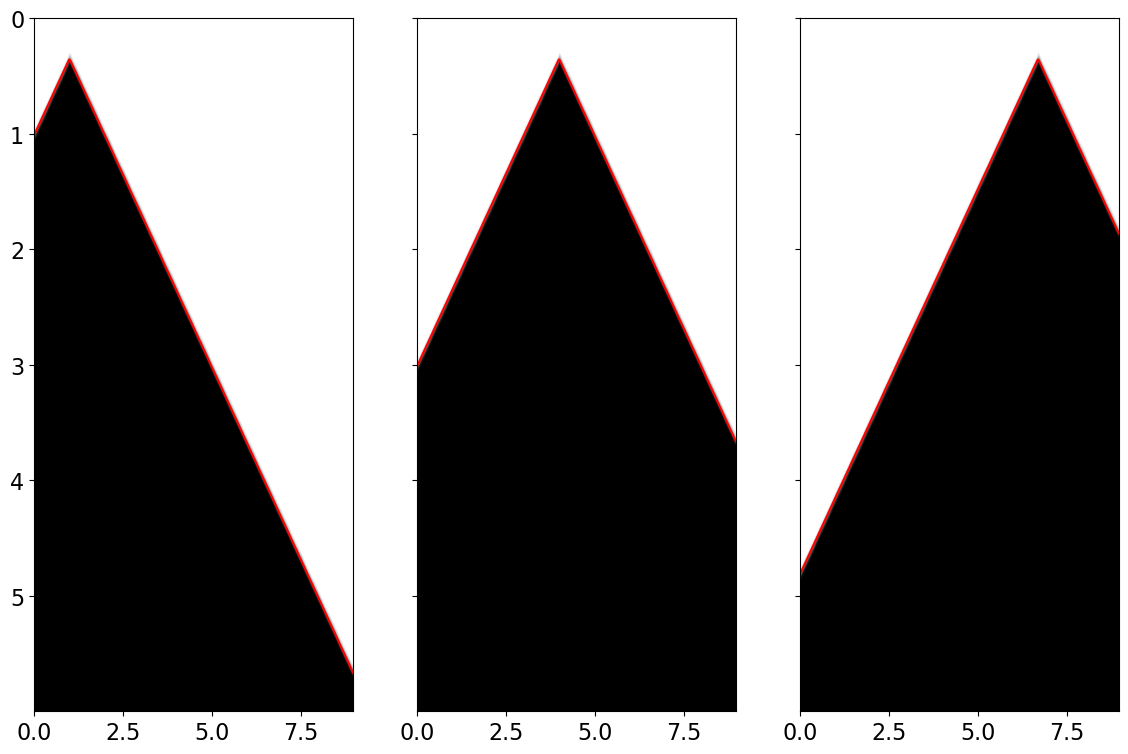

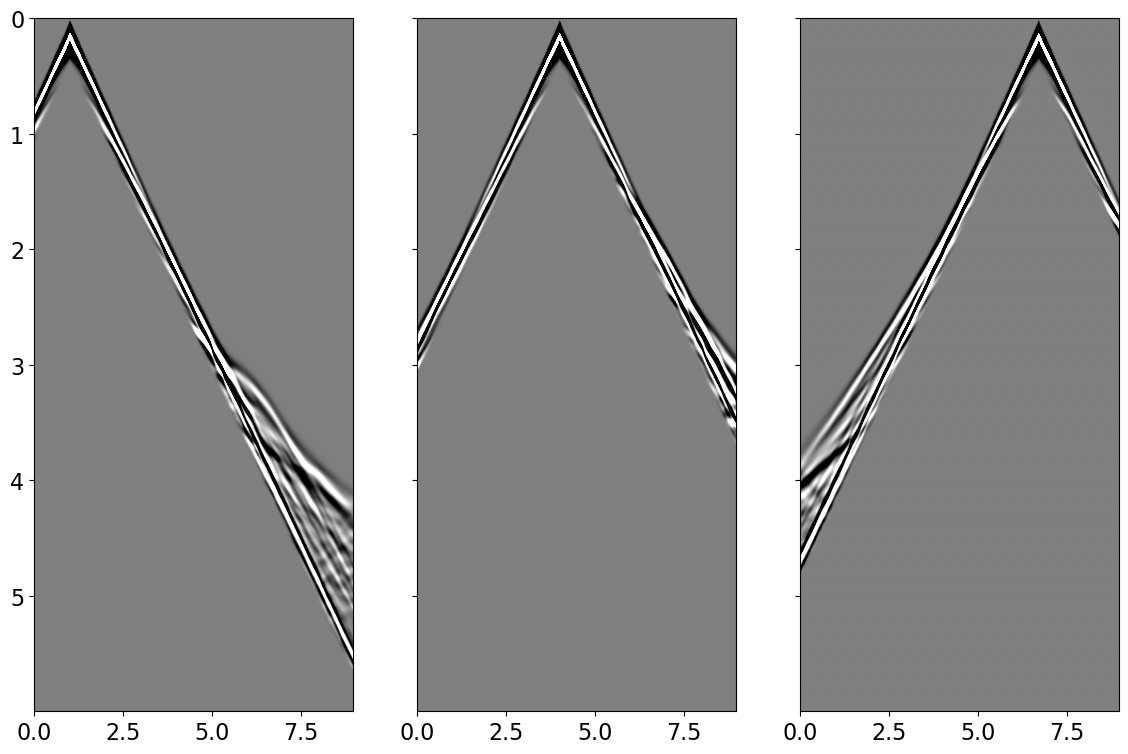

In [15]:
# Create direct arrival mask
distance = np.sqrt((x_s[:, 0][:, None]-x_r[:, 0][None, :])**2 + (x_s[:, 1][:, None]-x_r[:, 1][None, :])**2)
directtime = distance / vwater
tsmask = TimeSpaceMasking(directtime, geometry.nt, geometry.dt, toff, nsmooth=50)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)
    ax.plot(x_r[:, 0], directtime[ishot] + toff, 'r')
    
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(tsmask.mask[ishot].T, aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=0, vmax=1)
    ax.plot(x_r[:, 0], directtime[ishot] + toff, 'r')
    
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot] * tsmask.mask[ishot].T, aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax);

## Inversion with L-BFGS

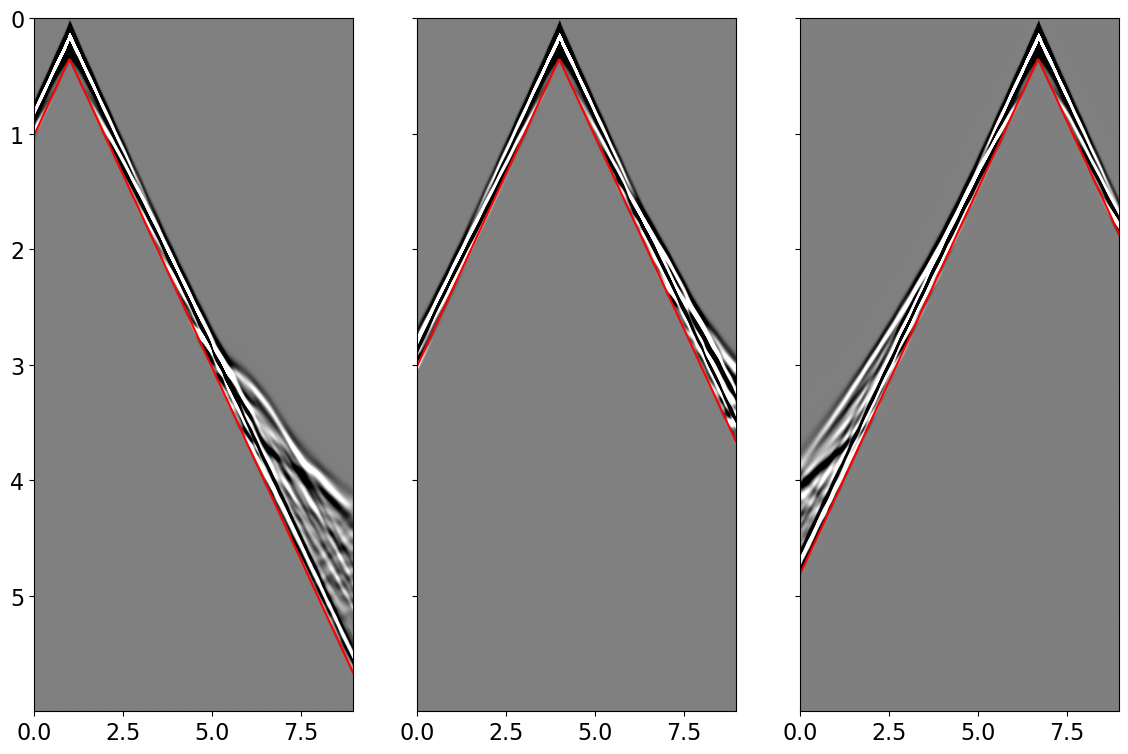

In [12]:
# Mask observed data to have direct arrival and refractions
TSmaskop = [Diagonal(tsmask.mask[isrc].T.ravel()) for isrc in range(par['ns'])]
dobs_masked = np.hstack([(TSmaskop[isrc] @ dobs[isrc].ravel())[None, :] for isrc in range(par['ns'])])
dobs_masked = dobs_masked.reshape(par['ns'], geometry.nt, par['nr'])

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs_masked[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)
    ax.plot(x_r[:, 0], directtime[ishot] + toff, 'r')

In [13]:
# Define loss (to which we add the mask as a diagonal linear operator applied to the modelled data
l2loss = L2(TSmaskop, dobs_masked.reshape(par['ns'], -1))

wav = geometry.src.wavelet
ainv = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,  
                      vprange=(vp_true.min(), vp_true.max()),
                      wav=wav, f0=par['freq'],
                      space_order=space_order, nbl=nbl,
                      loss=l2loss);

  0%|          | 0/20 [00:00<?, ?it/s]

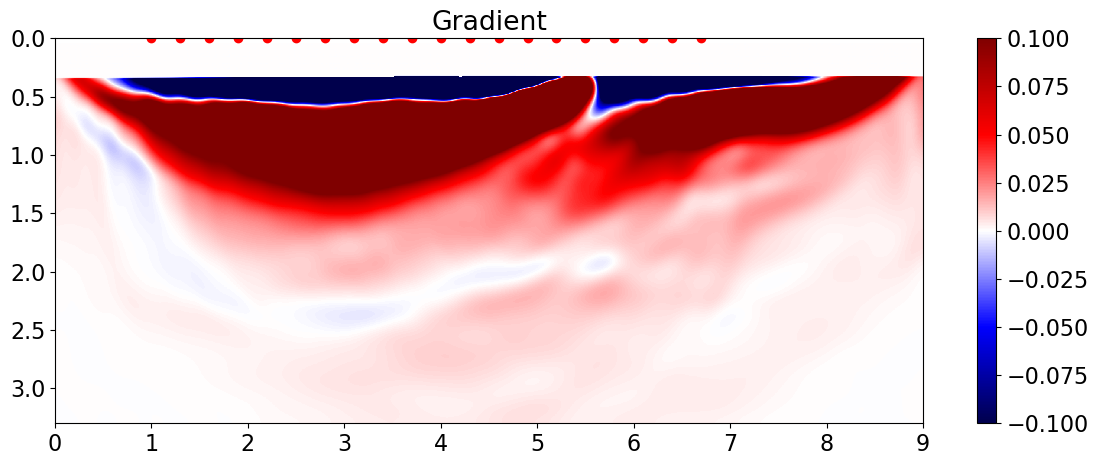

In [16]:
# Compute first gradient and find scaling
postproc = PostProcessVP(scaling=1, mask=msk, sigmas=(4, 4))
loss, direction = ainv._loss_grad(vp_init, postprocess=postproc.apply)

scaling = direction.max()

plt.figure(figsize=(14, 5))
plt.imshow(direction.T / scaling, cmap='seismic', vmin=-1e-1, vmax=1e-1, 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Gradient')
plt.axis('tight');

In [17]:
# FWI with L-BFGS
ftol = 1e-10
maxiter = 50
maxfun = 5000
vp_error = []

convertvp = None
postproc = PostProcessVP(scaling=scaling, mask=msk, sigmas=(4, 4)).apply

nl = minimize(ainv.loss_grad, vp_init.ravel(), method='L-BFGS-B', jac=True,
              args=(convertvp, postproc),
              callback=lambda x: fwi_callback(x, vp=vp_true, vp_error=vp_error), 
              options={'ftol':ftol, 'maxiter':maxiter, 'maxfun':maxfun, 'disp':True})

  0%|          | 0/20 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       132821     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76564D+02    |proj g|=  1.65189D+00


 This problem is unconstrained.


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    1    f=  5.59696D+02    |proj g|=  1.04642D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    2    f=  3.19453D+02    |proj g|=  8.74497D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    3    f=  2.33346D+02    |proj g|=  7.72401D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    4    f=  1.73086D+02    |proj g|=  3.76497D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    5    f=  1.52139D+02    |proj g|=  2.81240D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    6    f=  1.41462D+02    |proj g|=  1.81093D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    7    f=  1.26447D+02    |proj g|=  2.04470D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    8    f=  1.18849D+02    |proj g|=  2.78564D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    9    f=  1.11520D+02    |proj g|=  1.84430D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   10    f=  1.00465D+02    |proj g|=  1.04792D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   11    f=  9.32834D+01    |proj g|=  1.54386D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   12    f=  8.71220D+01    |proj g|=  3.15087D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   13    f=  8.06042D+01    |proj g|=  1.33046D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   14    f=  7.65465D+01    |proj g|=  1.17801D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   15    f=  7.04457D+01    |proj g|=  1.29906D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   16    f=  6.65421D+01    |proj g|=  1.30663D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   17    f=  6.31609D+01    |proj g|=  1.49024D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   18    f=  6.03860D+01    |proj g|=  8.67055D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   19    f=  5.80252D+01    |proj g|=  1.19457D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   20    f=  5.52983D+01    |proj g|=  9.31361D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   21    f=  5.40833D+01    |proj g|=  1.48127D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   22    f=  5.20910D+01    |proj g|=  5.87421D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   23    f=  5.08043D+01    |proj g|=  6.72448D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   24    f=  4.92780D+01    |proj g|=  8.05089D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   25    f=  4.65275D+01    |proj g|=  7.84344D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   26    f=  4.43931D+01    |proj g|=  1.92493D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   27    f=  4.24844D+01    |proj g|=  1.23559D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   28    f=  4.14938D+01    |proj g|=  6.39856D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   29    f=  4.04558D+01    |proj g|=  5.23004D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   30    f=  3.94821D+01    |proj g|=  1.12694D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   31    f=  3.87152D+01    |proj g|=  5.60390D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   32    f=  3.77667D+01    |proj g|=  3.93425D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   33    f=  3.60213D+01    |proj g|=  4.56040D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   34    f=  3.50702D+01    |proj g|=  1.33780D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   35    f=  3.42269D+01    |proj g|=  5.83096D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   36    f=  3.35078D+01    |proj g|=  3.28476D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   37    f=  3.28656D+01    |proj g|=  4.71440D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   38    f=  3.18443D+01    |proj g|=  6.34592D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   39    f=  3.07135D+01    |proj g|=  1.00715D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   40    f=  3.00486D+01    |proj g|=  1.38308D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   41    f=  2.93456D+01    |proj g|=  4.39760D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   42    f=  2.89746D+01    |proj g|=  4.37138D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   43    f=  2.86660D+01    |proj g|=  4.56434D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   44    f=  2.82350D+01    |proj g|=  4.50038D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   45    f=  2.74089D+01    |proj g|=  4.96199D-02


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   46    f=  2.68698D+01    |proj g|=  6.63723D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   47    f=  2.63709D+01    |proj g|=  3.17308D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   48    f=  2.59781D+01    |proj g|=  2.91906D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   49    f=  2.55117D+01    |proj g|=  7.23443D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   50    f=  2.51483D+01    |proj g|=  4.45747D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     50     52      1     0     0   4.457D-02   2.515D+01
  F =   25.148314179455951     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [18]:
nl

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 25.14831417945595
        x: [ 1.500e+00  1.500e+00 ...  4.088e+00  4.089e+00]
      nit: 50
      jac: [ 0.000e+00  0.000e+00 ...  9.789e-06  1.027e-05]
     nfev: 52
     njev: 52
 hess_inv: <132821x132821 LbfgsInvHessProduct with dtype=float64>

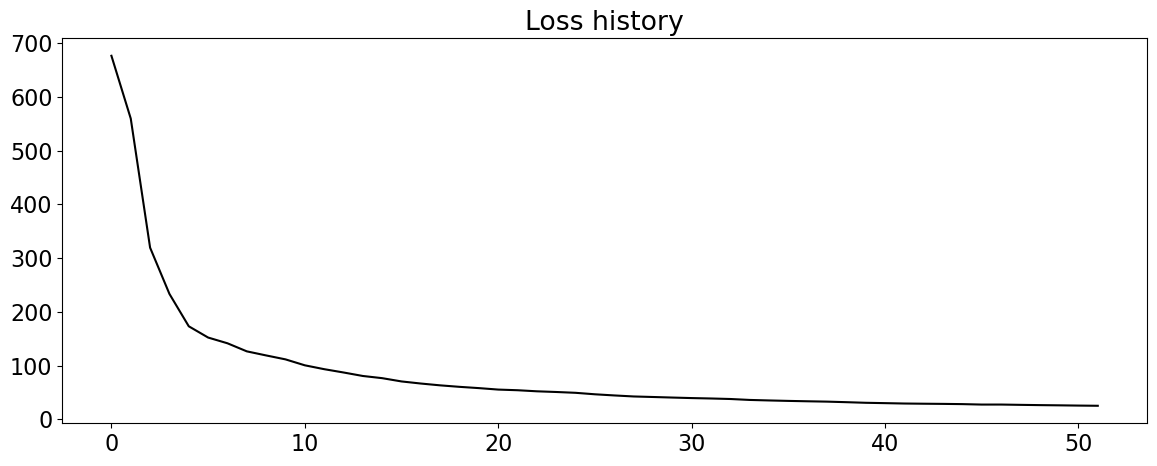

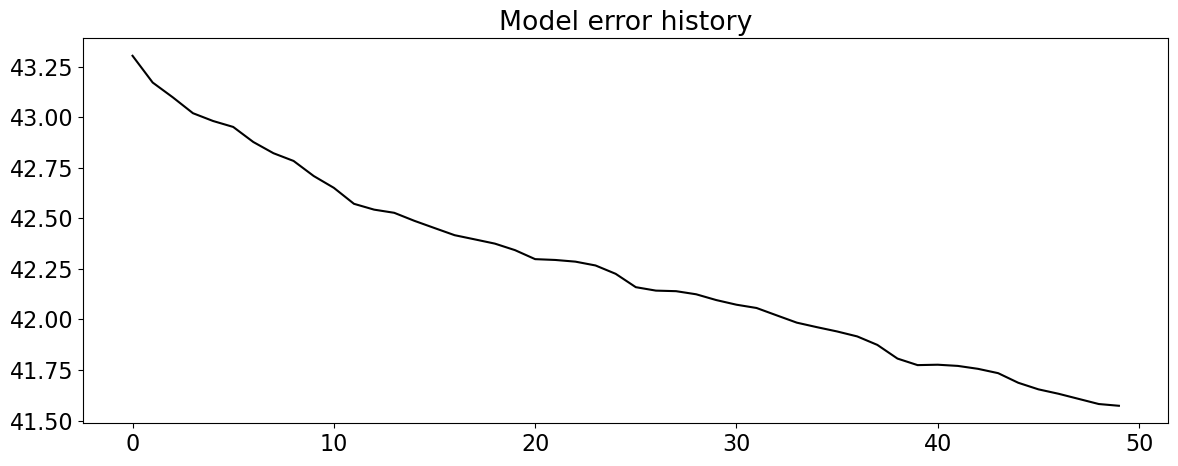

In [19]:
plt.figure(figsize=(14, 5))
plt.plot(ainv.losshistory, 'k')
plt.title('Loss history')

plt.figure(figsize=(14, 5))
plt.plot(vp_error, 'k')
plt.title('Model error history');

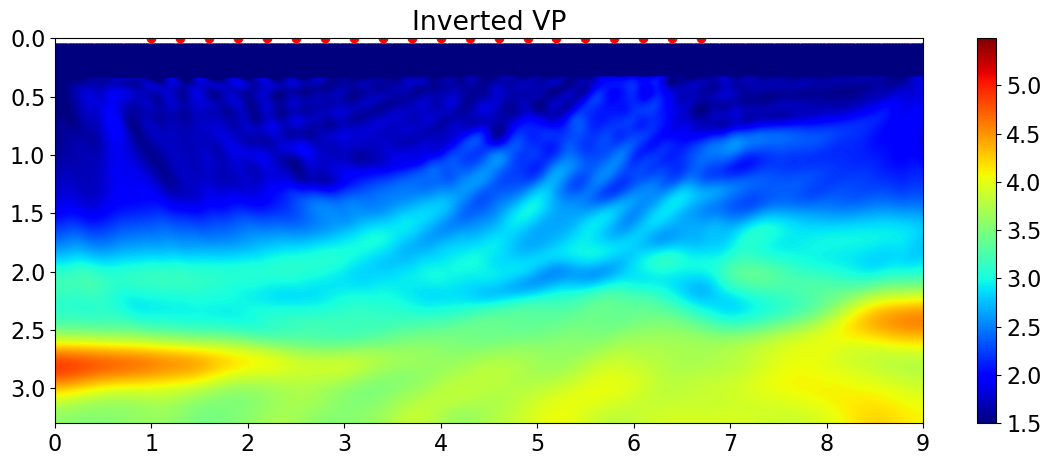

In [20]:
vp_inv = nl.x.reshape(shape)

plt.figure(figsize=(14, 5))
plt.imshow(vp_inv.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Inverted VP')
plt.axis('tight');

In [21]:
# Model data with inverted velocity model and compare with observed data
ainvfinal = AcousticWave2D(shape, origin, spacing, 
                           x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                           0., tmax,  
                           vp=vp_inv, 
                           src_type="Ricker", f0=par['freq'],
                           space_order=space_order, nbl=nbl)

dinv = ainvfinal.mod_allshots(dt=dtobs)[0]

  0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
# Mask predicted data
dinv_masked = np.hstack([(TSmaskop[isrc] @ dinv[isrc, :dobs.shape[1]].ravel())[None, :] for isrc in range(par['ns'])])
dinv_masked = dinv_masked.reshape(par['ns'], geometry.nt, par['nr'])

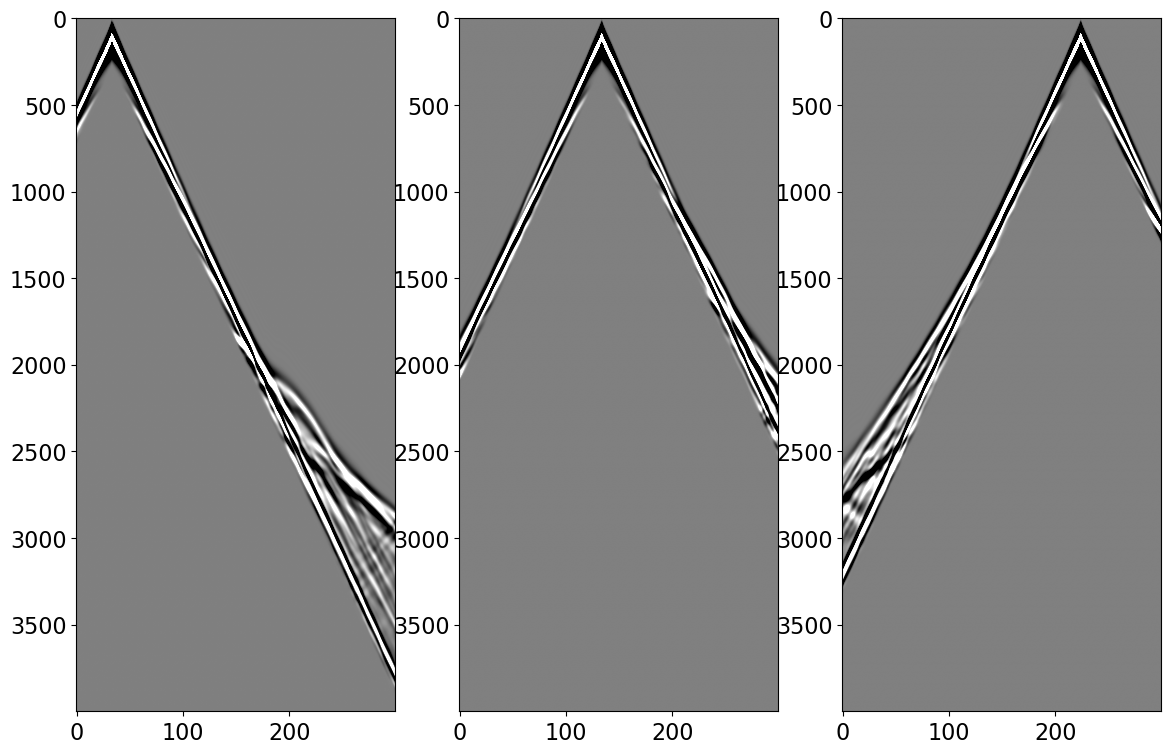

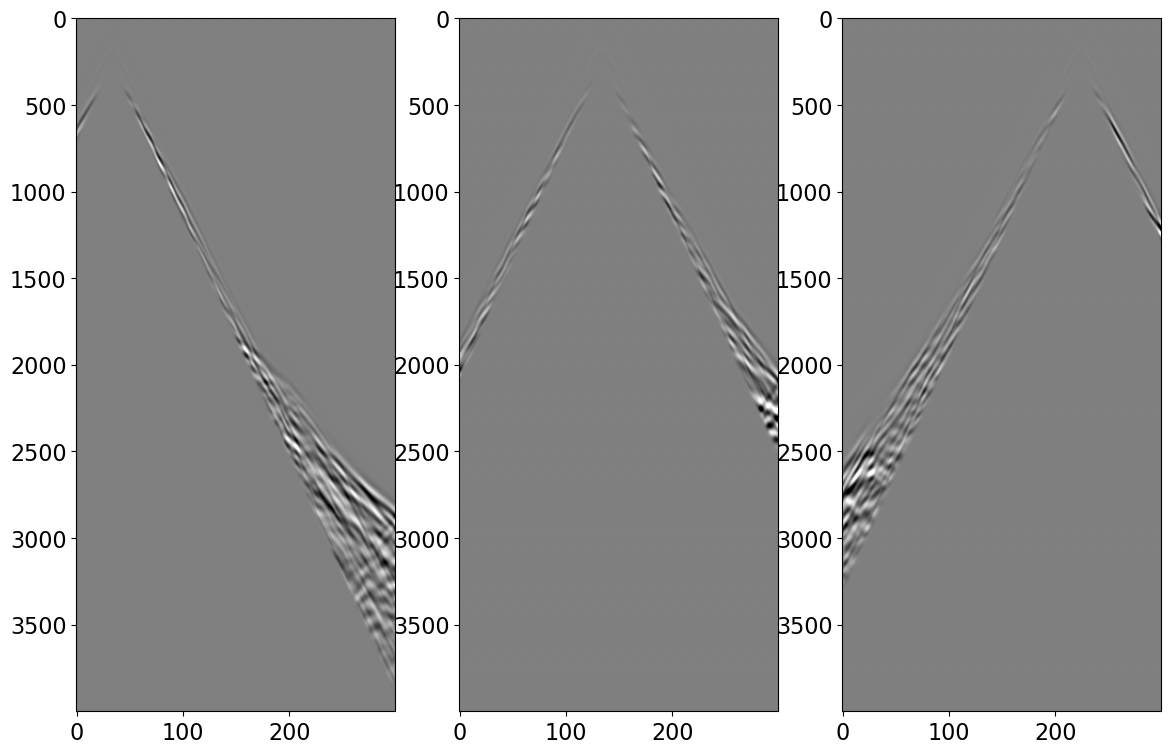

In [24]:
ntmax = 4000
d_vmin, d_vmax = np.percentile(np.hstack(dinv).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dinv_masked[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs_masked[ishot, :ntmax] - dinv_masked[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)